# GHP Construction with Duration Matching

In [2]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [4]:
erk.bond_price(20, 1000, 0.05, 2, 0.02)

1492.520291709342

In [5]:
erk.bond_price(20, 1000, 0.05, 2, 0.04)

1136.7773962036904

In [6]:
erk.bond_price(20, 1000, 0.05, 2, 0.05)

1000.0000000000023

In [7]:
rates = np.linspace(0.01, 0.1, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [10]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

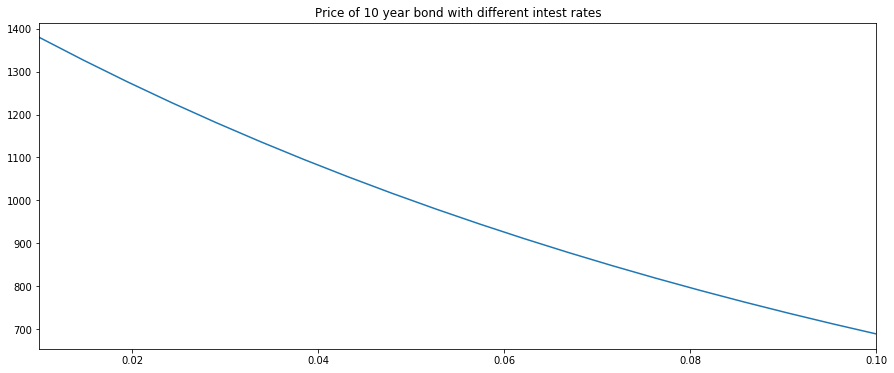

In [11]:
pd.DataFrame(data=prices, index=rates).plot(title='Price of 10 year bond with different intest rates', legend=False, figsize=(15, 6))

In [13]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [15]:
# time based discount
discounts = erk.discount(cf.index, 0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [17]:
# discounted cash flow
dcf = discounts*cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [19]:
# converting into weights
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [23]:
# weighted average of all the periods
(cf.index*weights).sum()

5.579707187194534

In [24]:
# weighted time duration
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

5.579707187194534

## Duration Matching

In [25]:
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [27]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)

In [28]:
md_10

8.190898824083233

In [29]:
md_20

13.544718122145921

d_l = Macaulay duration, long bond;
d_s = Macaulay duration, short bond;
d_t = Macaulay duration, target

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearraging gives:

$$ w_s = \frac{d_l - d_t}{d_l - d_s} $$

In [31]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [35]:
# price of the bonds
p_short = erk.bond_price(10, 1000, .05, 1, .04)
p_long = erk.bond_price(20, 1000, .05, 1, .04)
a_0 = 130000
# portfolio cash flows
p_flows = pd.concat([a_0*w_s*short_bond/p_short, a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

In [37]:
# current funding ratio
cfr = erk.funding_ratio(p_flows, liabilities, .04)
cfr

0.9998760012192478

In [42]:
rates = np.linspace(0, .1, 20)
# all in long bond
lb_assets = a_0*long_bond/p_long
# all in short bond
sb_assets = a_0*short_bond/p_short

fr_change = pd.DataFrame({
    'Long Bond': [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    'Short Bond': [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    'Duration Matched Bond': [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)

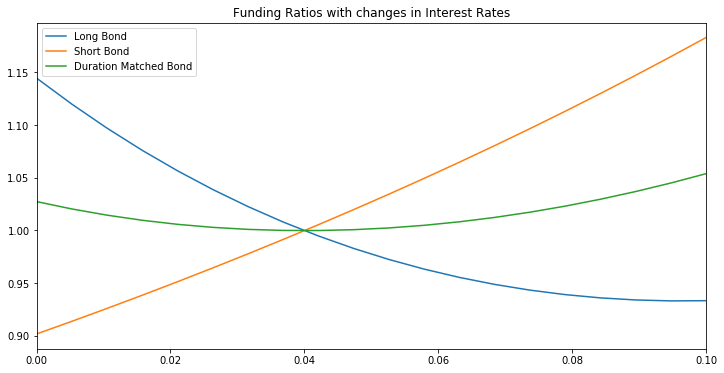

In [43]:
fr_change.plot(title='Funding Ratios with changes in Interest Rates', figsize=(12, 6))